In [1]:
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

In [2]:
# Load ARFF dataset
file_path = 'dataset/MagicTelescope.arff'
data_arff, meta = arff.loadarff(file_path)
data_df = pd.DataFrame(data_arff)

# Preprocessing
# Separate features and target
X = data_df.iloc[:, 1:-1]  # Exclude ID and class
y = data_df['class:'].apply(lambda x: x.decode('utf-8'))  # Decode bytes to string

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


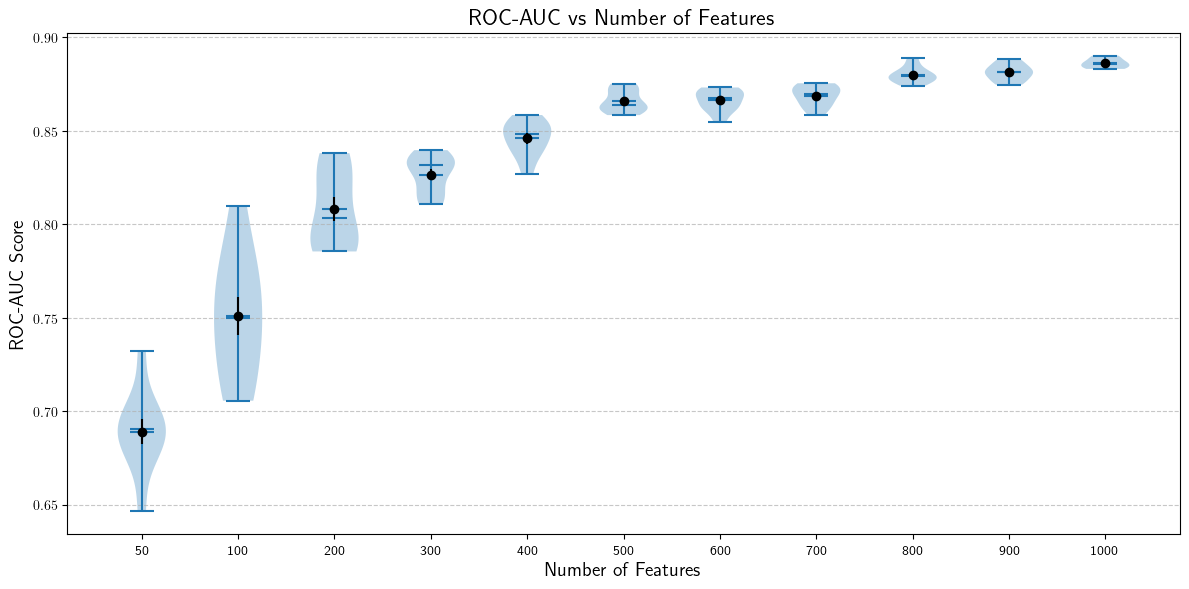

In [4]:
# Define a range of components for RFF
components_range = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
roc_auc_scores_all = {n_components: [] for n_components in components_range}

# Collect scores for each number of components
for n_components in components_range:
    for run in range(10):  # Repeat 10 runs for each number of components
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
        # Create a pipeline with the current number of components
        pipeline = make_pipeline(
            StandardScaler(),
            RBFSampler(gamma=1, random_state=run, n_components=n_components),  # Change random_state for variability
            SGDClassifier(max_iter=1000, tol=1e-3, random_state=run)
        )
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predict probabilities for ROC-AUC calculation
        y_prob = pipeline.decision_function(X_test)
        roc_auc = roc_auc_score(y_test, y_prob)
        roc_auc_scores_all[n_components].append(roc_auc)

# Prepare data for plotting
roc_auc_values = [roc_auc_scores_all[n] for n in components_range]
mean_scores = [np.mean(scores) for scores in roc_auc_values]
stderr_scores = [np.std(scores) / np.sqrt(len(scores)) for scores in roc_auc_values]

# Plot violin plot with Matplotlib

plt.figure(figsize=(12, 6))
plt.violinplot(roc_auc_values, showmeans=True, showextrema=True, showmedians=True)
# Use LateX for the labels
plt.rc('text', usetex=True)
# Add mean and standard error bars
plt.errorbar(
    x=np.arange(1, len(components_range) + 1),  # Matplotlib violin plots are 1-indexed
    y=mean_scores,
    yerr=stderr_scores,
    fmt='o',
    color='black',
    label='Mean ± Standard Error'
)

# Customize the plot
plt.title("ROC-AUC vs Number of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
plt.xticks(ticks=np.arange(1, len(components_range) + 1), labels=components_range)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('roc_auc_vs_n_features.pdf')
# plt.legend()
plt.tight_layout()

plt.show()

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define feature sizes and training set sizes
feature_sizes = [100, 300, 500, 700]  # Number of components for RFF
train_sizes = [0.05, 0.10, 0.20, 0.40, 0.80]  # Fractions of the dataset used for training

# Prepare storage for mean and standard error of ROC-AUC scores
results = {feature_size: {"means": [], "std_errs": []} for feature_size in feature_sizes}

# Iterate over feature sizes
for feature_size in feature_sizes:
    for train_size in train_sizes:
        roc_auc_scores = []
        
        # Repeat 10 runs for each configuration
        for run in range(10):
            # Split the dataset according to the current training set size
            X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=1-train_size, random_state=run)
            
            # Create a pipeline with the current feature size
            pipeline = make_pipeline(
                StandardScaler(),
                RBFSampler(gamma=1, random_state=run, n_components=feature_size),
                SGDClassifier(max_iter=1000, tol=1e-3, random_state=run)
            )
            
            # Train the model
            pipeline.fit(X_train, y_train)
            
            # Predict probabilities for ROC-AUC calculation
            y_prob = pipeline.decision_function(X_test)
            roc_auc = roc_auc_score(y_test, y_prob)
            roc_auc_scores.append(roc_auc)
        
        # Store mean and standard error for this configuration
        results[feature_size]["means"].append(np.mean(roc_auc_scores))
        results[feature_size]["std_errs"].append(np.std(roc_auc_scores) / np.sqrt(len(roc_auc_scores)))


In [19]:

krr_data = np.load('magic_krr_timings.npz')
summed = np.mean(krr_data['maes'], axis=0)
stdder = np.std(krr_data['maes'], axis=0) / np.sqrt(krr_data['maes'].shape[0])

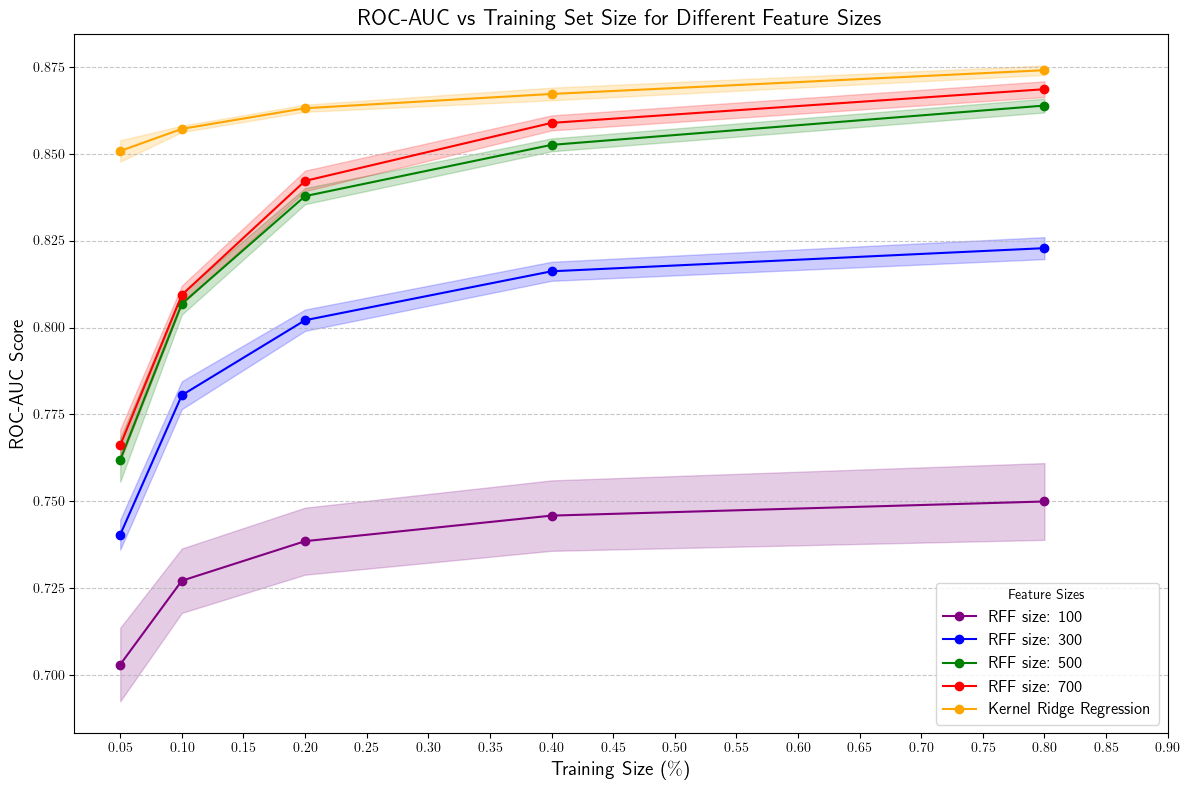

In [21]:
# Plot line plots
plt.figure(figsize=(12, 8))

for feature_size, color in zip(feature_sizes, ['purple', 'blue', 'green', 'red']):
    means = results[feature_size]["means"]
    std_errs = results[feature_size]["std_errs"]
    plt.plot(train_sizes, means, marker='o', linestyle='-', label=f'RFF size: {feature_size}', color=color)
    plt.fill_between(train_sizes, np.array(means) - np.array(std_errs), np.array(means) + np.array(std_errs), 
                     color=color, alpha=0.2)
plt.plot(train_sizes, summed, marker='o', linestyle='-', label='Kernel Ridge Regression', color='orange')
plt.fill_between(train_sizes, summed - stdder, summed + stdder, color='orange', alpha=0.2)
# Customize the plot
plt.rc('text', usetex=True)
plt.title("ROC-AUC vs Training Set Size for Different Feature Sizes", fontsize=16)
plt.xlabel("Training Size ($\%$)", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
# plt.xticks(ticks=train_sizes, labels=[f'{int(t * 100)}%' for t in train_sizes])
plt.xticks(ticks = np.arange(0.05, 0.95, 0.05))
plt.legend(title="Feature Sizes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('roc_auc_vs_training_size.pdf')
# Show the plot
plt.show()